In [2]:
from chess_winner.utils import fen_to_input_columns,transform_dataset,symbols_to_dict,input_columns_to_fen,dict_to_symbols
from chess_winner.data import load_model
from chess_winner.engine import Engine
import chess
import pandas as pd
import cairosvg
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from chess_winner.board import Board64
import chess.svg
import pickle
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

# Test the model 

**Extract a pgn for testing**

In [3]:
data = pd.read_csv('../raw_data/club_games_data.csv')
status = ['abandoned','resigned','timeout','repetition','timevsinsufficient','stalemate','insufficient','agreed','threecheck','kingofthehill','50move']
data = data[(~data['white_result'].isin(status))&(~data['black_result'].isin(status))].sample(frac=1).reset_index(drop=True)
data_sample = data[['white_result','black_result','pgn']].sample(100)

data_sample['result'] = data_sample['white_result'].map(lambda X: 1 if X=='win' else 0)

X = data_sample.drop(columns='result').reset_index(drop=True)
y = data_sample['result'].reset_index(drop=True)

**transform the pgn and calculate CP score**

In [5]:
os.environ["ENGINE_DEPTH"] = "5"
os.environ["ENGINE_TIMEOUT"] = "0.1"
os.environ["ENGINE_MATE_SCORE"] = "10000"
os.environ.get("ENGINE_DEPTH"),os.environ.get("ENGINE_TIMEOUT"),os.environ.get("ENGINE_MATE_SCORE")
results = transform_dataset(X,y,0,1000)

AttributeError: 'SimpleEngine' object has no attribute 'initialize'

In [4]:
results = results.drop(columns=[66])
results = symbols_to_dict(results)

In [4]:
dt = results.loc[:,65:68]
for i,x in dt.iterrows():
    print(str(dt.iloc[i][65])+' => '+ str(dt.iloc[i][67])+ ' => '+ str(dt.iloc[i][68]))

54 => rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w => rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w - - 0 1
68 => rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b => rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b - - 0 1
122 => rnbqkbnr/ppp1pppp/3p4/8/4P3/8/PPPP1PPP/RNBQKBNR w => rnbqkbnr/ppp1pppp/3p4/8/4P3/8/PPPP1PPP/RNBQKBNR w - - 0 1
23 => rnbqkbnr/ppp1pppp/3p4/8/2B1P3/8/PPPP1PPP/RNBQK1NR b => rnbqkbnr/ppp1pppp/3p4/8/2B1P3/8/PPPP1PPP/RNBQK1NR b - - 0 1
16 => rnbqkb1r/ppp1pppp/3p1n2/8/2B1P3/8/PPPP1PPP/RNBQK1NR w => rnbqkb1r/ppp1pppp/3p1n2/8/2B1P3/8/PPPP1PPP/RNBQK1NR w - - 0 1
-21 => rnbqkb1r/ppp1pppp/3p1n2/8/2B1P3/3P4/PPP2PPP/RNBQK1NR b => rnbqkb1r/ppp1pppp/3p1n2/8/2B1P3/3P4/PPP2PPP/RNBQK1NR b - - 0 1
0 => rnbqkb1r/ppp1pp1p/3p1np1/8/2B1P3/3P4/PPP2PPP/RNBQK1NR w => rnbqkb1r/ppp1pp1p/3p1np1/8/2B1P3/3P4/PPP2PPP/RNBQK1NR w - - 0 1
16 => rnbqkb1r/ppp1pp1p/3p1np1/8/2B1P3/2NP4/PPP2PPP/R1BQK1NR b => rnbqkb1r/ppp1pp1p/3p1np1/8/2B1P3/2NP4/PPP2PPP/R1BQK1NR b - - 0 1
55 => rnbqk2r/ppp1ppbp/3p1n

**Load the last model to test**

In [6]:
model = pickle.load(open('../backend/model/chess_winner_classifier_model.pkl', 'rb'))

**Predict the probas**

In [11]:
predicts = model.predict_proba(results)

**Define svg for each position**

In [12]:
board = Board64(y[0],Engine())
moves = board.get_moves(X.loc[0,"pgn"])
# for each moves try to execute and add to grid
svgs=[chess.svg.board(board.board,size=300)]
for i,move in enumerate(moves):
    board.board.push_san(move)
    svgs.append(chess.svg.board(board.board,size=300))

**Display the results**

rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b
rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w
rnbqkbnr/pppp1ppp/8/4p3/2B1P3/8/PPPP1PPP/RNBQK1NR b
rnbqkb1r/pppp1ppp/5n2/4p3/2B1P3/8/PPPP1PPP/RNBQK1NR w
rnbqkb1r/pppp1ppp/5n2/4p3/2B1P3/5N2/PPPP1PPP/RNBQK2R b
rnbqk2r/pppp1ppp/5n2/2b1p3/2B1P3/5N2/PPPP1PPP/RNBQK2R w
rnbqk2r/pppp1ppp/5n2/2b1p3/2B1P3/3P1N2/PPP2PPP/RNBQK2R b
rnbqk2r/ppp2ppp/5n2/2bpp3/2B1P3/3P1N2/PPP2PPP/RNBQK2R w
rnbqk2r/ppp2ppp/5n2/2bpp3/2B1P3/2PP1N2/PP3PPP/RNBQK2R b
rnbqk2r/ppp2ppp/5n2/3pp3/2B1P3/2PP1N2/PP3bPP/RNBQK2R w
rnbqk2r/ppp2ppp/5n2/3pp3/2B1P3/2PP1N2/PP3KPP/RNBQ3R b
rnbqk2r/ppp2ppp/5n2/4p3/2p1P3/2PP1N2/PP3KPP/RNBQ3R w
rnbqk2r/ppp2ppp/5n2/4p3/2P1P3/2P2N2/PP3KPP/RNBQ3R b
rnbqk2r/ppp2ppp/8/4p3/2P1n3/2P2N2/PP3KPP/RNBQ3R w
rnbqk2r/ppp2ppp/8/4p3/2P1n3/2P2N2/PP4PP/RNBQK2R b
rn1qk2r/pppb1ppp/8/4p3/2P1n3/2P2N2/PP4PP/RNBQK2R w
rn1qk2r/pppb1ppp/8/4p3/2P1n3/2P2N2/PP2Q1PP/RNB1K2R b
rn1qk2r/ppp2ppp/8/4pb2/2P1n3/2P2N2/PP2Q1PP/RNB1K2R w

(49, 25, 49)

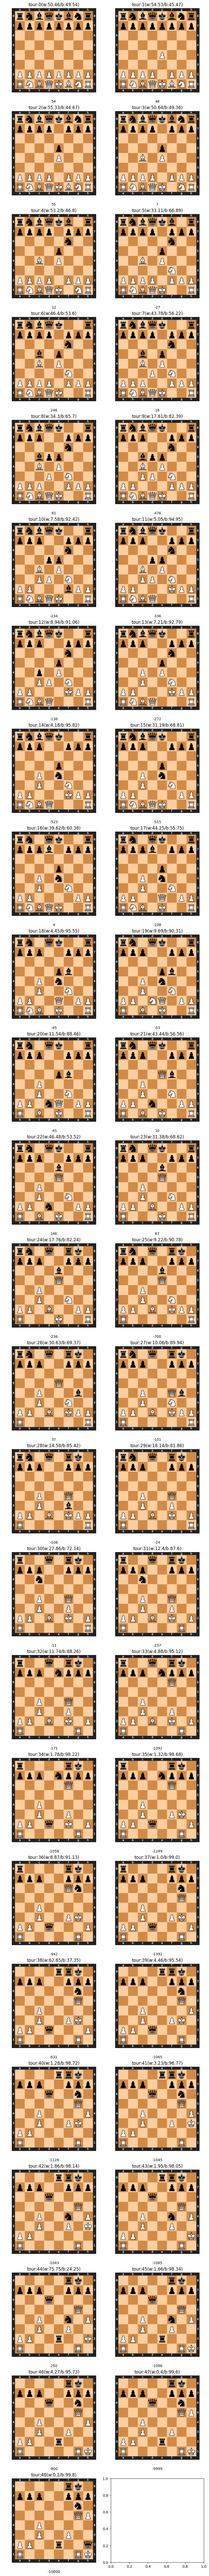

In [13]:
col = 2
rows = int(len(svgs)/col)+1
#fig, axs = plt.subplots(rows,4,figsize=(15, 6), facecolor='lightskyblue',layout='constrained',)
#rows=10
fig, axs = plt.subplots(rows,col,figsize=(8, 100),layout='constrained')

preds = predicts
cpt=0
for i in range(rows):
    for k in range(col):
        if cpt<len(svgs):
            symbols = dict_to_symbols(results.iloc[(cpt):(cpt+1),0:64])
            symbols[64]=results.iloc[(cpt):(cpt+1),64]
            axs[i][k].imshow(Image.open(BytesIO(cairosvg.svg2png(svgs[cpt])))) 
            axs[i][k].set_title(f'tour:{cpt}(w:{round(preds[cpt][1]*100,2)}/b:{round(preds[cpt][0]*100,2)})')
            axs[i][k].tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
            axs[i][k].set_xlabel(results.iloc[cpt,65])
            print(input_columns_to_fen(symbols))
        cpt+=1

len(svgs),rows,len(results)

# Define another rescue model for specific issues

**Load preprocessed data**

In [22]:
df_preprocessed_symbols = pd.read_csv('../raw_data/club_games_data_preprocessed_symbols.csv')
df_preprocessed_symbols.columns=range(0,67)

**Look at the distribution**

(-15000.0, 15000.0)

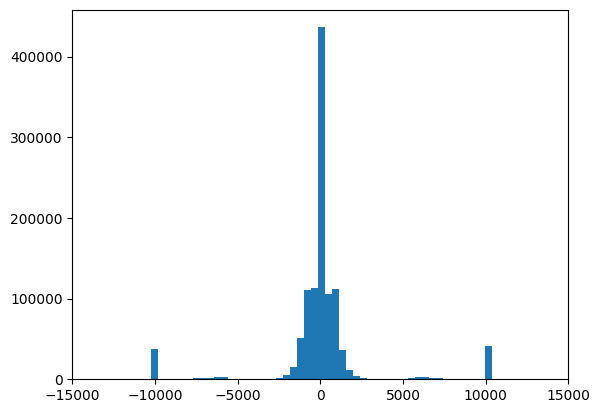

In [23]:
import matplotlib.pyplot as plt
plt.hist(df_preprocessed_symbols[65],bins=50)
plt.xlim((-15000,15000))

**shuffle the dataset**

In [69]:
shuffled = df_preprocessed_symbols.sample(frac=1).reset_index()

**Extract target y and features X (CP + turn) and scale**

In [71]:
X = df_preprocessed_symbols[[64,65]]
y = df_preprocessed_symbols[66]

**Train and test split**

In [72]:
# define the train and test split
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.20,random_state=42)

**Grid search**

In [34]:
grid_search = GridSearchCV(
    SVC(),
    param_grid={
        'kernel':['poly'] ,
        'C':[1],
        'coef0':[1],
        'degree':[2,3,4,5]
    },
    cv=5,
    verbose=2,
    return_train_score=True,
    scoring='accuracy')
#grid_search.get_params()

In [ ]:
grid_search.fit(X_train[0:10000], y_train[0:10000])
grid_search.best_params_,grid_search.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ................C=1, coef0=1, degree=2, kernel=poly; total time=   1.4s
[CV] END ................C=1, coef0=1, degree=2, kernel=poly; total time=   1.2s
[CV] END ................C=1, coef0=1, degree=2, kernel=poly; total time=   1.6s
[CV] END ................C=1, coef0=1, degree=2, kernel=poly; total time=   1.3s
[CV] END ................C=1, coef0=1, degree=2, kernel=poly; total time=   1.1s
[CV] END ................C=1, coef0=1, degree=3, kernel=poly; total time=   1.3s
[CV] END ................C=1, coef0=1, degree=3, kernel=poly; total time=   1.7s
[CV] END ................C=1, coef0=1, degree=3, kernel=poly; total time=   1.5s
[CV] END ................C=1, coef0=1, degree=3, kernel=poly; total time=   1.5s
[CV] END ................C=1, coef0=1, degree=3, kernel=poly; total time=   1.5s
[CV] END ................C=1, coef0=1, degree=4, kernel=poly; total time=   1.7s
[CV] END ................C=1, coef0=1, degree=4, 

In [16]:
best_model = grid_search.best_estimator_
best_model.score(X_test,y_test)

0.7222224718596238

**pipeline a basic logistic regression**

In [74]:
preprocessor = ColumnTransformer([('cp_scaler',MinMaxScaler(),[1])])
pipe = make_pipeline(preprocessor,LogisticRegression())

In [75]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cp_scaler', MinMaxScaler(),
                                                  [1])])),
                ('logisticregression', LogisticRegression())])

In [76]:
pipe.score(X_test,y_test)

0.7274528746994989

In [81]:
X_test[0:1]

,64,65
633376,1,9998


In [101]:
X_test=pd.DataFrame(columns=[64,65])
X_test[[64,65]]=[[1,204]]

In [102]:
X_test

,64,65
0,1,204


In [103]:
predicts = pipe.predict_proba(X_test)
predicts

array([[0.40640716, 0.59359284]])

In [100]:
predicts[0][1]

0.5251718171557933

**Save the model**

In [104]:
# save pickle
model_pkl_file = "../backend/model/chess_winner_classifier_model_CP.pkl" 

pickle.dump(pipe, open(model_pkl_file, 'wb'))